# Implementation of DANN with GRL for UDA on DCASE TAU URBAN 2020

In [1]:
import os
import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from hear21passt.base import get_basic_model
import time
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
from collections import defaultdict

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [3]:
DATA_PATH = "./dcase"
BATCH_SIZE = 32  
MAX_EPOCHS = 50
LEARNING_RATE = 0.0005  
PRINT_EVERY_N_STEPS = 100

In [4]:
class GradientReversalFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)
    
    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.lambda_
        return output, None

class GradientReversalLayer(nn.Module):
    def __init__(self, lambda_=1.0):
        super(GradientReversalLayer, self).__init__()
        self.lambda_ = lambda_
    
    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)
    
    def set_lambda(self, lambda_):
        self.lambda_ = lambda_


In [5]:
class AudioDataset(Dataset):
    def __init__(self, audio_files, labels, devices, label_to_idx, target_sr=32000, max_len_seconds=10, use_labels=True):
        self.audio_files = audio_files
        self.labels = labels
        self.devices = devices
        self.label_to_idx = label_to_idx
        self.target_sr = target_sr
        self.max_len_samples = target_sr * max_len_seconds
        self.use_labels = use_labels
    
    def __len__(self):
        return len(self.audio_files)
    
    def __getitem__(self, idx):
        file_path = self.audio_files[idx]
        label = self.labels[idx]
        device = self.devices[idx]
        
        label_idx = self.label_to_idx[label] if self.use_labels else -1
        domain = 1 if device == 'a' else 0
        
        waveform, sr = librosa.load(file_path, sr=self.target_sr, mono=True)
        
        if len(waveform) < self.max_len_samples:
            pad_len = self.max_len_samples - len(waveform)
            waveform = np.pad(waveform, (0, pad_len))
        else:
            waveform = waveform[:self.max_len_samples]
        
        return torch.tensor(waveform, dtype=torch.float32), label_idx, domain, device


In [6]:
class PASSETFeatureExtractor(nn.Module):
    def __init__(self, freeze_passt=True):
        super(PASSETFeatureExtractor, self).__init__()
        self.passt_model = get_basic_model(mode="embed_only")
        self.passt_model.eval()
        
        if freeze_passt:
            for param in self.passt_model.parameters():
                param.requires_grad = False
        
        self.feature_dim = 768

        self.adaptation_layers = nn.Sequential(
            nn.Linear(self.feature_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3)
        )
        
    def forward(self, x):
        with torch.no_grad():
            passt_features = self.passt_model(x)
        adapted_features = self.adaptation_layers(passt_features)
        return adapted_features


In [7]:
class Classifier(nn.Module):
    def __init__(self, input_size=256, num_classes=10):
        super(Classifier, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(64, num_classes),
        )
        
    def forward(self, h):
        return self.layer(h)


In [8]:
class Discriminator(nn.Module):
    def __init__(self, input_size=256, num_classes=1):
        super(Discriminator, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes),
            nn.Sigmoid(),
        )
    
    def forward(self, h):
        return self.layer(h)

In [9]:
def get_lambda(epoch, max_epoch, gamma=10.0, max_lambda=1.0):
    p = epoch / max_epoch
    return max_lambda * (2. / (1 + np.exp(-gamma * p)) - 1.)


In [10]:
def extract_info_from_filename(filename):
    parts = filename.replace('.wav', '').split('-')
    scene = parts[0]
    device = parts[-1]
    return scene, device


In [11]:
def load_audio_files(folder_path):
    files = []
    labels = []
    devices = []
    
    if not os.path.exists(folder_path):
        return files, labels, devices
    
    for filename in os.listdir(folder_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(folder_path, filename)
            scene, device = extract_info_from_filename(filename)
            files.append(file_path)
            labels.append(scene)
            devices.append(device)
    
    return files, labels, devices


In [12]:
def load_dataset(data_path):
    train_source_path = os.path.join(data_path, "train", "source")
    train_target_path = os.path.join(data_path, "train", "target")
    test_source_path = os.path.join(data_path, "test","source")
    test_target_path = os.path.join(data_path, "test","target")
    
    train_source_files, train_source_labels, train_source_devices = load_audio_files(train_source_path)
    train_target_files, train_target_labels, train_target_devices = load_audio_files(train_target_path)
    test_source_files, test_source_labels, test_source_devices = load_audio_files(test_source_path)
    test_target_files, test_target_labels, test_target_devices = load_audio_files(test_target_path)
    
    
    all_labels = set(train_source_labels + test_source_labels+test_target_labels)
    label_to_idx = {label: idx for idx, label in enumerate(sorted(all_labels))}
    idx_to_label = {idx: label for label, idx in label_to_idx.items()}
    
    print(f"Found {len(all_labels)} classes: {sorted(all_labels)}")
    print(f"Train source (device 'a'): {len(train_source_files)} files")
    print(f"Train target (devices {sorted(set(train_target_devices))}): {len(train_target_files)} files")
    print(f"Test source (devices {sorted(set(test_source_devices))}): {len(test_source_files)} files")
    print(f"Test target (devices {sorted(set(test_target_devices))}): {len(test_target_files)} files")

    
    return (train_source_files, train_source_labels, train_source_devices,
            train_target_files, train_target_labels, train_target_devices,
            test_source_files, test_source_labels, test_source_devices,
            test_target_files, test_target_labels, test_target_devices,
            label_to_idx, idx_to_label)

(train_src_files, train_src_labels, train_src_devices,
 train_tgt_files, train_tgt_labels, train_tgt_devices,
 test_source_files, test_source_labels, test_source_devices,
 test_target_files, test_target_labels, test_target_devices,
 label_to_idx, idx_to_label) = load_dataset(DATA_PATH)
num_classes = len(label_to_idx)
print(f"Number of classes: {num_classes}")


Found 10 classes: ['airport', 'bus', 'metro', 'metro_station', 'park', 'public_square', 'shopping_mall', 'street_pedestrian', 'street_traffic', 'tram']
Train source (device 'a'): 10215 files
Train target (devices ['b', 'c', 's1', 's2', 's3']): 3747 files
Test source (devices ['a']): 330 files
Test target (devices ['b', 'c', 's1', 's2', 's3', 's4', 's5', 's6']): 2638 files
Number of classes: 10


In [13]:
def create_validation_split(files, labels, devices, val_ratio=0.1):
    n_val = int(len(files) * val_ratio)
    
    train_files = files[n_val:]
    train_labels = labels[n_val:]
    train_devices = devices[n_val:]
    val_files = files[:n_val]
    val_labels = labels[:n_val]
    val_devices = devices[:n_val]
    
    return train_files, train_labels, train_devices, val_files, val_labels, val_devices


In [14]:
def create_data_loaders(train_source_files, train_source_labels, train_source_devices,
                        train_target_files, train_target_labels, train_target_devices,
                        test_source_files, test_source_labels, test_source_devices,
                        test_target_files, test_target_labels, test_target_devices,
                        label_to_idx, batch_size=32):
    
    train_src_files, train_src_labels, train_src_devices, val_src_files, val_src_labels, val_src_devices = create_validation_split(
        train_source_files, train_source_labels, train_source_devices)
    train_tgt_files, train_tgt_labels, train_tgt_devices, val_tgt_files, val_tgt_labels, val_tgt_devices = create_validation_split(
        train_target_files, train_target_labels, train_target_devices)
    
    train_source_dataset = AudioDataset(train_src_files, train_src_labels, train_src_devices, label_to_idx, use_labels=True)
    val_source_dataset = AudioDataset(val_src_files, val_src_labels, val_src_devices, label_to_idx, use_labels=True)
    train_target_dataset = AudioDataset(train_tgt_files, train_tgt_labels, train_tgt_devices, label_to_idx, use_labels=False)
    val_target_dataset = AudioDataset(val_tgt_files, val_tgt_labels, val_tgt_devices, label_to_idx, use_labels=False)
    test_source_dataset = AudioDataset(test_source_files, test_source_labels, test_source_devices, label_to_idx, use_labels=True)
    test_target_dataset = AudioDataset(test_target_files, test_target_labels, test_target_devices, label_to_idx, use_labels=True)   
    
    
    train_source_loader = DataLoader(train_source_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    train_target_loader = DataLoader(train_target_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_source_loader = DataLoader(val_source_dataset, batch_size=batch_size, shuffle=False)
    val_target_loader = DataLoader(val_target_dataset, batch_size=batch_size, shuffle=False)
    test_source_loader = DataLoader(test_source_dataset, batch_size=batch_size, shuffle=False)
    test_target_loader = DataLoader(test_target_dataset, batch_size=batch_size, shuffle=False)
    
    print(f"Training - Source: {len(train_src_files)}, Target: {len(train_tgt_files)}")
    print(f"Validation - Source: {len(val_src_files)}, Target: {len(val_tgt_files)}")
    print(f"Test -Source: {len(test_source_files)}, Target: {len(test_target_files)}")
    
    return train_source_loader, train_target_loader, val_source_loader, val_target_loader, test_source_loader,test_target_loader

train_src_loader, train_tgt_loader, val_src_loader, val_tgt_loader, test_source_loader,test_target_loader=create_data_loaders(
    train_src_files, train_src_labels, train_src_devices,
    train_tgt_files, train_tgt_labels, train_tgt_devices,
    test_source_files, test_source_labels, test_source_devices,
    test_target_files, test_target_labels, test_target_devices,
    label_to_idx, BATCH_SIZE
)

Training - Source: 9194, Target: 3373
Validation - Source: 1021, Target: 374
Test -Source: 330, Target: 2638


In [15]:
F = PASSETFeatureExtractor().to(DEVICE)
C = Classifier(input_size=256, num_classes=num_classes).to(DEVICE)
D = Discriminator(input_size=256).to(DEVICE)
GRL = GradientReversalLayer().to(DEVICE)



 Loading PASST TRAINED ON AUDISET 


PaSST(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), ep

In [16]:
def evaluate_classification(feature_extractor, classifier, data_loader):
    feature_extractor.eval()
    classifier.eval()
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for audio, labels, domains, devices in data_loader:
            valid_mask = labels != -1
            if not valid_mask.any():
                continue
                
            audio = audio[valid_mask].to(DEVICE)
            labels = labels[valid_mask].to(DEVICE)
            
            features = feature_extractor(audio)
            outputs = classifier(features)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total if total > 0 else 0
    feature_extractor.train()
    classifier.train()
    
    return accuracy


In [17]:
def evaluate_by_device(F, C, data_loader, idx_to_label):
    F.eval()
    C.eval()
    
    device_stats = defaultdict(lambda: {'correct': 0, 'total': 0, 'predictions': [], 'labels': []})
    
    with torch.no_grad():
        for audio, labels, domains, devices in data_loader:
            valid_mask = labels != -1
            if not valid_mask.any():
                continue
                
            audio = audio[valid_mask].to(DEVICE)
            labels = labels[valid_mask]
            devices = [devices[i] for i in range(len(devices)) if valid_mask[i]]
            
            features = F(audio)
            outputs = C(features)
            _, predicted = torch.max(outputs.data, 1)
            
            for i, device in enumerate(devices):
                device_stats[device]['total'] += 1
                device_stats[device]['labels'].append(labels[i].item())
                device_stats[device]['predictions'].append(predicted[i].cpu().item())
                if predicted[i].cpu().item() == labels[i].item():
                    device_stats[device]['correct'] += 1
    
    results = {}
    for device, stats in device_stats.items():
        if stats['total'] > 0:
            accuracy = stats['correct'] / stats['total']
            results[device] = {
                'accuracy': accuracy,
                'total_samples': stats['total'],
                'predictions': stats['predictions'],
                'labels': stats['labels']
            }
    
    return results


In [18]:
def train_dann_improved(train_source_loader, train_target_loader, val_source_loader, val_target_loader,
                       num_classes, max_epochs=50, lr=0.001, print_every_n_steps=100):
    
    bce_loss = nn.BCELoss()
    ce_loss = nn.CrossEntropyLoss()
    
    F_opt = optim.Adam(F.parameters(), lr=lr, weight_decay=1e-5)
    C_opt = optim.Adam(C.parameters(), lr=lr, weight_decay=1e-5)
    D_opt = optim.Adam(D.parameters(), lr=lr*2, weight_decay=1e-5)
    
    F_scheduler = optim.lr_scheduler.StepLR(F_opt, step_size=20, gamma=0.5)
    C_scheduler = optim.lr_scheduler.StepLR(C_opt, step_size=20, gamma=0.5)
    D_scheduler = optim.lr_scheduler.StepLR(D_opt, step_size=20, gamma=0.5)
    
    history = {
        'cls_loss': [],
        'disc_loss': [],
        'src_acc': [],
        'domain_acc': [],
        'lambda_values': []
    }
    
    target_iter = iter(train_target_loader)
    global_step = 0
    
    def get_target_batch():
        nonlocal target_iter
        try:
            return next(target_iter)
        except StopIteration:
            target_iter = iter(train_target_loader)
            return next(target_iter)
    
    for epoch in range(1, max_epochs + 1):
        F.train()
        C.train()
        D.train()
        
        epoch_cls_loss = 0
        epoch_disc_loss = 0
        total_domain_correct = 0
        total_domain_samples = 0
        
        for batch_idx, (src_audio, src_labels, src_domains, src_devices) in enumerate(train_source_loader):
            global_step += 1
            tgt_audio, tgt_labels, tgt_domains, tgt_devices = get_target_batch()
            
            src_audio = src_audio.to(DEVICE)
            src_labels = src_labels.to(DEVICE)
            src_domains = src_domains.float().unsqueeze(1).to(DEVICE)
            
            tgt_audio = tgt_audio.to(DEVICE)
            tgt_domains = tgt_domains.float().unsqueeze(1).to(DEVICE)
            
            batch_size = src_audio.size(0)
            domain_labels = torch.cat([src_domains, tgt_domains], dim=0)
            

            src_features = F(src_audio)
            tgt_features = F(tgt_audio)
            all_features = torch.cat([src_features, tgt_features], dim=0)
            
            for _ in range(2):  
                D_opt.zero_grad()
                domain_pred = D(all_features.detach())
                disc_loss = bce_loss(domain_pred, domain_labels)
                disc_loss.backward()
                D_opt.step()
            
            with torch.no_grad():
                domain_pred_eval = D(all_features.detach())
                domain_pred_binary = (domain_pred_eval > 0.5).float()
                domain_correct = (domain_pred_binary == domain_labels).sum().item()
                total_domain_correct += domain_correct
                total_domain_samples += domain_labels.size(0)

            F_opt.zero_grad()
            C_opt.zero_grad()

            src_features = F(src_audio)
            tgt_features = F(tgt_audio)
            all_features = torch.cat([src_features, tgt_features], dim=0)          

            class_pred = C(src_features)
            cls_loss = ce_loss(class_pred, src_labels)
            
            lambda_grl = get_lambda(epoch-1, max_epochs, gamma=10.0)
            GRL.set_lambda(lambda_grl)

            reversed_features = GRL(all_features)
            domain_pred_adv = D(reversed_features)

            adv_loss = bce_loss(domain_pred_adv, domain_labels)

            adv_weight = min(0.5, lambda_grl * 0.5) 
            total_loss = cls_loss + adv_weight * adv_loss
            
            total_loss.backward()
            
            torch.nn.utils.clip_grad_norm_(F.parameters(), max_norm=1.0)
            torch.nn.utils.clip_grad_norm_(C.parameters(), max_norm=1.0)
            
            F_opt.step()
            C_opt.step()
            
            epoch_cls_loss += cls_loss.item()
            epoch_disc_loss += disc_loss.item()

            if global_step % print_every_n_steps == 0:
                current_time = time.strftime("%H:%M:%S")
                print(f"Epoch: {epoch}/{max_epochs}, Step: {global_step}, "
                      f"D Loss: {disc_loss.item():.4f}, C Loss: {cls_loss.item():.4f}, "
                      f"lambda: {lambda_grl:.4f} ---- {current_time}")

        F_scheduler.step()
        C_scheduler.step()
        D_scheduler.step()
        
        history['cls_loss'].append(epoch_cls_loss / len(train_source_loader))
        history['disc_loss'].append(epoch_disc_loss / len(train_source_loader))
        history['domain_acc'].append(total_domain_correct / total_domain_samples)
        history['lambda_values'].append(lambda_grl)

        if epoch % 5 == 0:
            src_acc = evaluate_classification(F, C, val_source_loader)
            history['src_acc'].append(src_acc)
            
            current_time = time.strftime("%H:%M:%S")
            domain_acc = total_domain_correct/total_domain_samples
            print(f"Epoch {epoch}/{max_epochs} Validation - Source Acc: {src_acc:.4f}, "
                  f"Domain Acc: {domain_acc:.4f}, Lambda: {lambda_grl:.4f} ---- {current_time}")

            if epoch % 10 == 0:
                test_results = evaluate_by_device(F, C, val_target_loader, {})
                if test_results:
                    avg_target_acc = np.mean([r['accuracy'] for r in test_results.values()])
                    print(f"Target Domain Acc: {avg_target_acc:.4f}")
            
            print("-" * 80)
    
    return F, C, D, history

F, C, D, history = train_dann_improved(
    train_src_loader, train_tgt_loader, val_src_loader, val_tgt_loader,
    num_classes, MAX_EPOCHS, LEARNING_RATE, PRINT_EVERY_N_STEPS
)

/home/teaching/miniconda3/lib/python3.12/site-packages/torch/functional.py:730: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at /pytorch/aten/src/ATen/native/SpectralOps.cpp:875.)
  return _VF.stft(  # type: ignore[attr-defined]
/home/teaching/miniconda3/lib/python3.12/site-packages/hear21passt/models/preprocess.py:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


x torch.Size([32, 1, 128, 1000])
self.norm(x) torch.Size([32, 768, 12, 99])
 patch_embed :  torch.Size([32, 768, 12, 99])
 self.time_new_pos_embed.shape torch.Size([1, 768, 1, 99])
 self.freq_new_pos_embed.shape torch.Size([1, 768, 12, 1])
X flattened torch.Size([32, 1188, 768])
 self.new_pos_embed.shape torch.Size([1, 2, 768])
 self.cls_tokens.shape torch.Size([32, 1, 768])
 self.dist_token.shape torch.Size([32, 1, 768])
 final sequence x torch.Size([32, 1190, 768])
 after 12 atten blocks x torch.Size([32, 1190, 768])
forward_features torch.Size([32, 768])


/home/teaching/miniconda3/lib/python3.12/site-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*1000) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")


head torch.Size([32, 527])
Epoch: 1/50, Step: 100, D Loss: 0.6942, C Loss: 1.4889, lambda: 0.0000 ---- 17:13:56
Epoch: 1/50, Step: 200, D Loss: 0.6911, C Loss: 1.3472, lambda: 0.0000 ---- 17:21:37
Epoch: 2/50, Step: 300, D Loss: 0.6955, C Loss: 1.1547, lambda: 0.0997 ---- 17:29:20
Epoch: 2/50, Step: 400, D Loss: 0.6831, C Loss: 0.9095, lambda: 0.0997 ---- 17:36:42
Epoch: 2/50, Step: 500, D Loss: 0.6872, C Loss: 0.7921, lambda: 0.0997 ---- 17:44:06
Epoch: 3/50, Step: 600, D Loss: 0.6992, C Loss: 0.8506, lambda: 0.1974 ---- 17:51:28
Epoch: 3/50, Step: 700, D Loss: 0.6837, C Loss: 0.8445, lambda: 0.1974 ---- 17:58:47
Epoch: 3/50, Step: 800, D Loss: 0.6875, C Loss: 0.8289, lambda: 0.1974 ---- 18:06:05
Epoch: 4/50, Step: 900, D Loss: 0.6593, C Loss: 0.6351, lambda: 0.2913 ---- 18:13:21
Epoch: 4/50, Step: 1000, D Loss: 0.6942, C Loss: 0.5477, lambda: 0.2913 ---- 18:20:34
Epoch: 4/50, Step: 1100, D Loss: 0.6253, C Loss: 0.5977, lambda: 0.2913 ---- 18:27:47
Epoch: 5/50, Step: 1200, D Loss: 0.7

In [19]:
def create_confusion_matrix(F, C, data_loader, idx_to_label, title="Confusion Matrix"):
    F.eval()
    C.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for audio, labels, domains, devices in data_loader:
            valid_mask = labels != -1
            if not valid_mask.any():
                continue
                
            audio = audio[valid_mask].to(DEVICE)
            labels = labels[valid_mask]
            
            features = F(audio)
            outputs = C(features)
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    if len(all_labels) == 0:
        print(f"No valid labels found for {title}")
        return None
    
    label_names = [idx_to_label[i] for i in range(len(idx_to_label))]
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title(title)
    plt.tight_layout()
    plt.show()
    
    return cm



Final Source Domain Validation Accuracy: 0.8923

Test Set Performance by Device:
Device a (Source, Real): 0.7667 (330 samples)
Device b (Target, Real): 0.6869 (329 samples)
Device c (Target, Real): 0.7416 (329 samples)
Device s1 (Target, Simulated): 0.6364 (330 samples)
Device s2 (Target, Simulated): 0.5909 (330 samples)
Device s3 (Target, Simulated): 0.6182 (330 samples)
Device s4 (Target, Simulated): 0.6212 (330 samples)
Device s5 (Target, Simulated): 0.6182 (330 samples)
Device s6 (Target, Simulated): 0.6121 (330 samples)

Real Target Devices Average: 0.7143
Simulated Target Devices Average: 0.6162

Test Source Accuracy: 0.7667
Test Target Accuracy: 0.6406
Overall Test Accuracy (combined): 0.7037


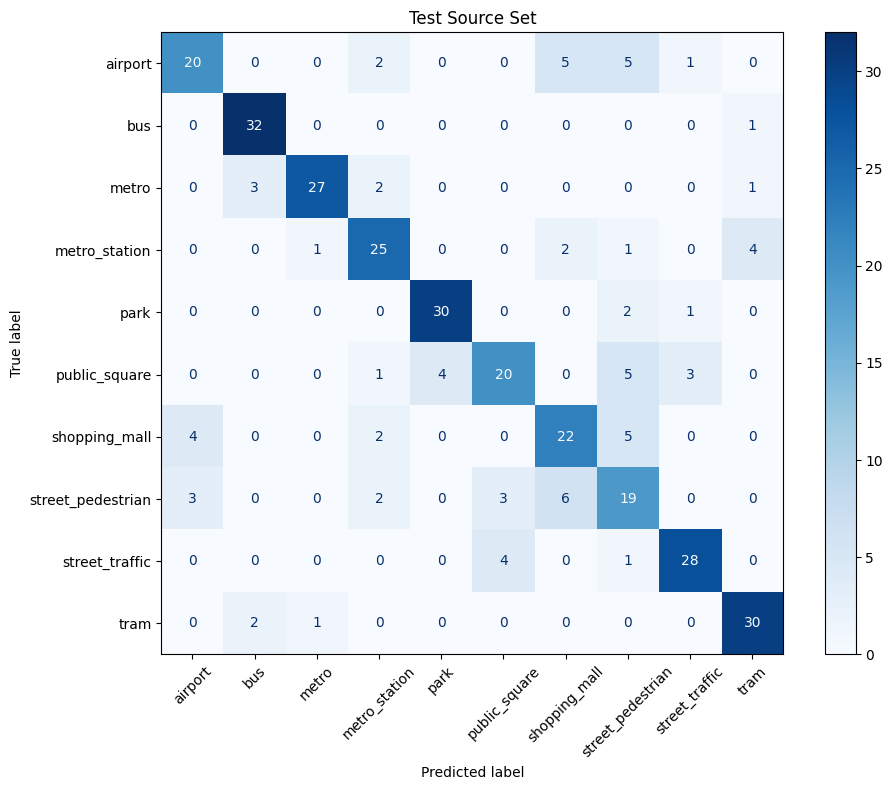

/home/teaching/miniconda3/lib/python3.12/site-packages/hear21passt/models/preprocess.py:71: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/teaching/miniconda3/lib/python3.12/site-packages/hear21passt/models/passt.py:304: UserWarning: Input image size (128*1000) doesn't match model (128*998).
  warnings.warn(f"Input image size ({H}*{W}) doesn't match model ({self.img_size[0]}*{self.img_size[1]}).")


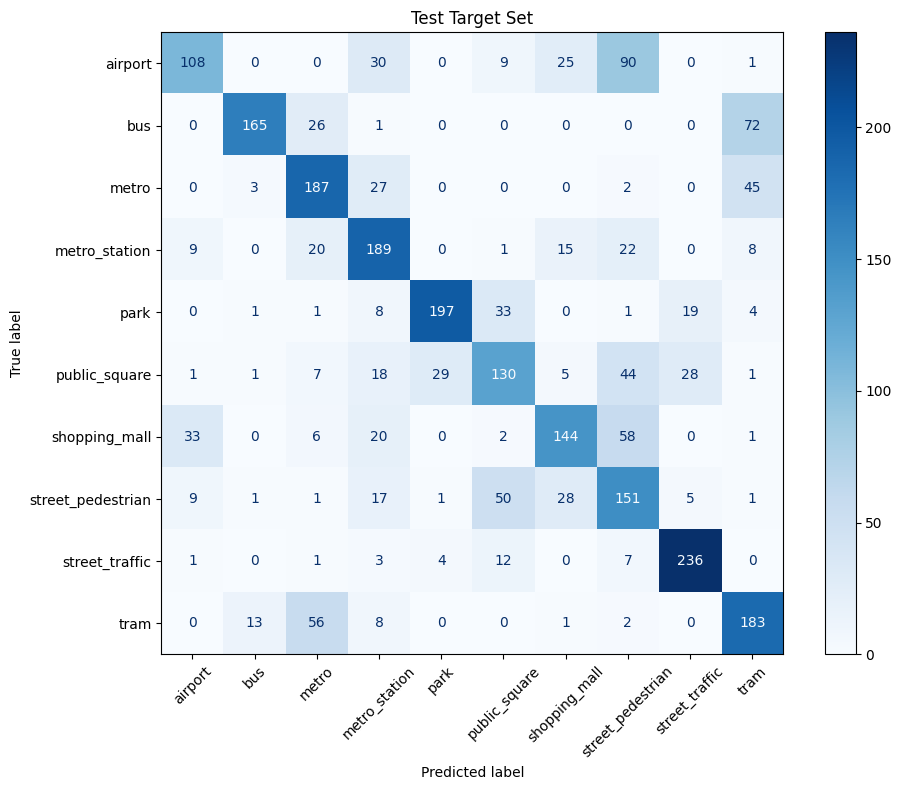

array([[108,   0,   0,  30,   0,   9,  25,  90,   0,   1],
       [  0, 165,  26,   1,   0,   0,   0,   0,   0,  72],
       [  0,   3, 187,  27,   0,   0,   0,   2,   0,  45],
       [  9,   0,  20, 189,   0,   1,  15,  22,   0,   8],
       [  0,   1,   1,   8, 197,  33,   0,   1,  19,   4],
       [  1,   1,   7,  18,  29, 130,   5,  44,  28,   1],
       [ 33,   0,   6,  20,   0,   2, 144,  58,   0,   1],
       [  9,   1,   1,  17,   1,  50,  28, 151,   5,   1],
       [  1,   0,   1,   3,   4,  12,   0,   7, 236,   0],
       [  0,  13,  56,   8,   0,   0,   1,   2,   0, 183]])

In [24]:
# Final source validation accuracy
final_src_acc = evaluate_classification(F, C, val_src_loader)
print(f"\nFinal Source Domain Validation Accuracy: {final_src_acc:.4f}")

# Evaluate test performance by device
print("\nTest Set Performance by Device:")
test_results = evaluate_by_device(F, C, test_source_loader, idx_to_label)
test_results_t = evaluate_by_device(F, C, test_target_loader, idx_to_label)
test_results.update(test_results_t)
real_devices = []
sim_devices = []

for device, results in sorted(test_results.items()):
    domain_type = "Source" if device == 'a' else "Target"
    device_type = "Real" if device in ['a', 'b', 'c'] else "Simulated"
    print(f"Device {device} ({domain_type}, {device_type}): {results['accuracy']:.4f} ({results['total_samples']} samples)")
    
    if device != 'a': 
        if device in ['b', 'c']:
            real_devices.append(results['accuracy'])
        else:
            sim_devices.append(results['accuracy'])

if real_devices:
    print(f"\nReal Target Devices Average: {np.mean(real_devices):.4f}")
if sim_devices:
    print(f"Simulated Target Devices Average: {np.mean(sim_devices):.4f}")

# Evaluate overall test accuracy on source and target separately
test_src_acc = evaluate_classification(F, C, test_source_loader)
test_tgt_acc = evaluate_classification(F, C, test_target_loader)

print(f"\nTest Source Accuracy: {test_src_acc:.4f}")
print(f"Test Target Accuracy: {test_tgt_acc:.4f}")
print(f"Overall Test Accuracy (combined): {(test_src_acc + test_tgt_acc) / 2:.4f}")

# Create confusion matrices separately or combined
create_confusion_matrix(F, C, test_source_loader, idx_to_label, "Test Source Set")
create_confusion_matrix(F, C, test_target_loader, idx_to_label, "Test Target Set")


In [21]:
import os
import torch

def save_dann_model(F, C, D, save_dir='checkpoints', filename_prefix='dann_model'):
    os.makedirs(save_dir, exist_ok=True)
    
    save_path = os.path.join(save_dir, f'{filename_prefix}.pt')
    torch.save({
        'feature_extractor_state_dict': F.state_dict(),
        'classifier_state_dict': C.state_dict(),
        'discriminator_state_dict': D.state_dict()
    }, save_path)
    
    print(f"✅ Model saved to {save_path}")

In [ ]:
save_dann_model(F, C, D, save_dir='saved_models/dann_w_grl', filename_prefix='dann_dcase')
